In [5]:
import numpy as np
import csv
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import least_squares
from scipy.integrate import odeint
import pandas as pd
import re

In [8]:
df = pd.read_csv('project10_data.csv')

# Initialize the max

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")

# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


In [54]:
# Get population
population = df["Population"][0]
accumulated_cases = np.array(df_clean.iloc[0])
accumulated_deaths = np.array(df_clean.iloc[1])

T_max = 119
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 - 7]

# When accumulated_deaths > 5, the simulation starts
t_deaths_0 = np.argwhere(accumulated_deaths > 5)[1, 0]
accumulated_deaths_after_t0 = accumulated_deaths[t_deaths_0:t_deaths_0+T_max+1]


In [16]:
# Exercise 1

omegas = []
for alpha in np.linspace(0.05, 0.2, 10):
    for f0 in np.linspace(1.5, 1.9, 10):
        beta = alpha * f0
        for p in np.linspace(0.02, 0.1, 10):
            omegas.append((alpha, beta, p * population))

print(f"Number of simulations: {len(omegas)}")

Number of simulations: 1000


In [17]:
def f(y, t, alpha, beta):
    S, I, R = y
    d0 = -alpha * S * I  # derivative of S(t)
    d1 = alpha * S * I - beta * I  # derivative of I(t)
    d2 = beta * I  # derivative of R(t)
    return [d0, d1, d2]


def SIR_simulation(alpha, beta, N):
    y_0 = [1, I[0] / N, 0]  # Susceptible, Infected, Recovered

    t = np.arange(start=1, stop=T_max+1.01, step=0.01)
    y = odeint(partial(f, alpha=alpha, beta=beta), y_0, t)
    y = y[::100]

    return y[:, 0] * N, y[:, 1] * N, y[:, 2] * N

In [59]:
# p = [1, 2, np.inf]
p = 1
lambda_ = 1
minimum = None
all_results = []

for alpha, beta, N in omegas:
    S_sim, I_sim, R_sim = SIR_simulation(alpha, beta, N)
    # gamma = np.argmin
    # accumulated_deaths - R_sim
    # solve gamma = argmin gamma ||accumulated_deaths - gamma*R_sim||_p
    gamma = least_squares(lambda x: np.linalg.norm(accumulated_deaths_after_t0 - x * R_sim, ord=p), 1, bounds=(0, 1))
    gamma = gamma.x[0]
    # print(f"alpha: {alpha}, beta: {beta}, N: {N}, gamma: {gamma}")
    # J = np.linalg.norm(accumulated_deaths[:T_max+1] - gamma * R_sim, ord=p) ** p
    summation = 0
    for i in range(T_max+1):
        summation += (I[i] - I_sim[i]) ** 2
    
    for i in range(T_max+1):
        summation += lambda_ * (accumulated_deaths_after_t0[i] - gamma * R_sim[i]) ** 2
    
    if minimum is None or summation < minimum[0]:
        minimum = (summation, alpha, beta, N, gamma)
    
    all_results.append((summation, alpha, beta, N, gamma))

J, alpha, beta, N, gamma = minimum
all_results = np.array(all_results)
print(f"alpha: {alpha}, beta: {beta}, N: {N}, gamma: {gamma}, J: {J}")
    

alpha: 0.05, beta: 0.07500000000000001, N: 88154.90000000001, gamma: 0.6267918219152258, J: 27984386.427122656


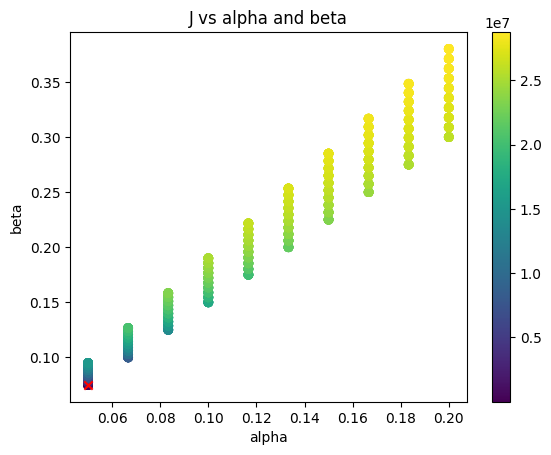

In [60]:

plt.figure()
plt.scatter(all_results[:, 1], all_results[:, 2], c=all_results[:, 0])

# plot the minimum
plt.scatter(alpha, beta, c="red", marker="x")

plt.xlabel("alpha")
plt.ylabel("beta")
plt.title("J vs alpha and beta")
plt.colorbar()
plt.clim(np.min(all_results[:, 0]), np.max(all_results[:, 0]))
plt.show()


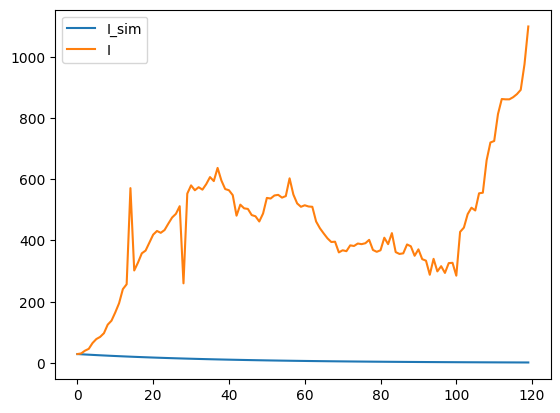

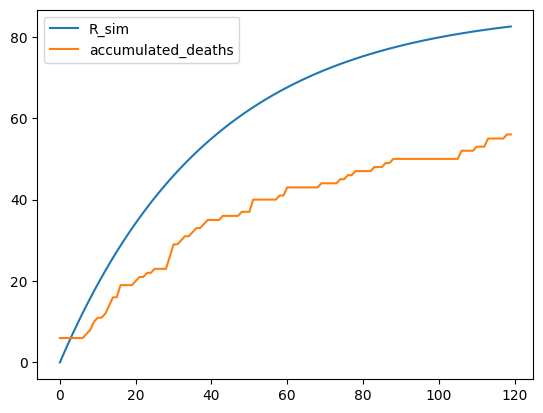

In [61]:

S_sim, I_sim, R_sim = SIR_simulation(alpha, beta, N)

plt.figure()
plt.plot(I_sim, label="I_sim")
plt.plot(I, label="I")
plt.legend()

plt.figure()
plt.plot(R_sim, label="R_sim")
plt.plot(accumulated_deaths_after_t0, label="accumulated_deaths")
plt.legend()